Contest link: https://www.kaggle.com/competitions/aimasters2022ml3hw4-license-plates

In [159]:
import os
import cv2
import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torch.nn.functional import ctc_loss, log_softmax
from torchvision import models

from string import digits, ascii_uppercase

np.random.seed(4321)

---

# Data preparation

## Create configs

In [164]:
PATH_TO_CLEAN_DATA = "/kaggle/input/aimasters2022ml3hw4-license-plates/train/train/simple/"
PATH_TO_DIRT_DATA = "/kaggle/input/aimasters2022ml3hw4-license-plates/train/train/complex/"
PATH_TO_TEST_DATA = "/kaggle/input/aimasters2022ml3hw4-license-plates/test/test/"


In [165]:
def get_text(filename):
    filename_before_dot = filename.split(".")[0]
    return filename_before_dot.split("_")[-1]
    
print(get_text('rus_00003_B026CO90.png'))

B026CO90


In [166]:
simple_config = []
complex_config = []
mix_config = []
test_config = []

for file in os.listdir(PATH_TO_CLEAN_DATA):
    simple_config.append({"file": PATH_TO_CLEAN_DATA + file, "text": get_text(file)})
    mix_config.append({"file": PATH_TO_CLEAN_DATA + file, "text": get_text(file)})

for file in os.listdir(PATH_TO_DIRT_DATA):
    complex_config.append({"file": PATH_TO_DIRT_DATA + file, "text": get_text(file)})
    mix_config.append({"file": PATH_TO_DIRT_DATA + file, "text": get_text(file)})

for file in os.listdir(PATH_TO_TEST_DATA):
    test_config.append({"file": PATH_TO_TEST_DATA + file, "text": file.split(".")[0]})
    
print(simple_config[0], len(simple_config), sep="\n")
print(complex_config[0], len(complex_config), sep="\n")
print(mix_config[0], len(mix_config), sep="\n")
print(test_config[0], len(test_config), sep="\n")


{'file': '/kaggle/input/aimasters2022ml3hw4-license-plates/train/train/simple/rus_07613_T446PX98.png', 'text': 'T446PX98'}
11801
{'file': '/kaggle/input/aimasters2022ml3hw4-license-plates/train/train/complex/rus_11494_A310CB35.png', 'text': 'A310CB35'}
16252
{'file': '/kaggle/input/aimasters2022ml3hw4-license-plates/train/train/simple/rus_07613_T446PX98.png', 'text': 'T446PX98'}
28053
{'file': '/kaggle/input/aimasters2022ml3hw4-license-plates/test/test/4353.png', 'text': '4353'}
7012


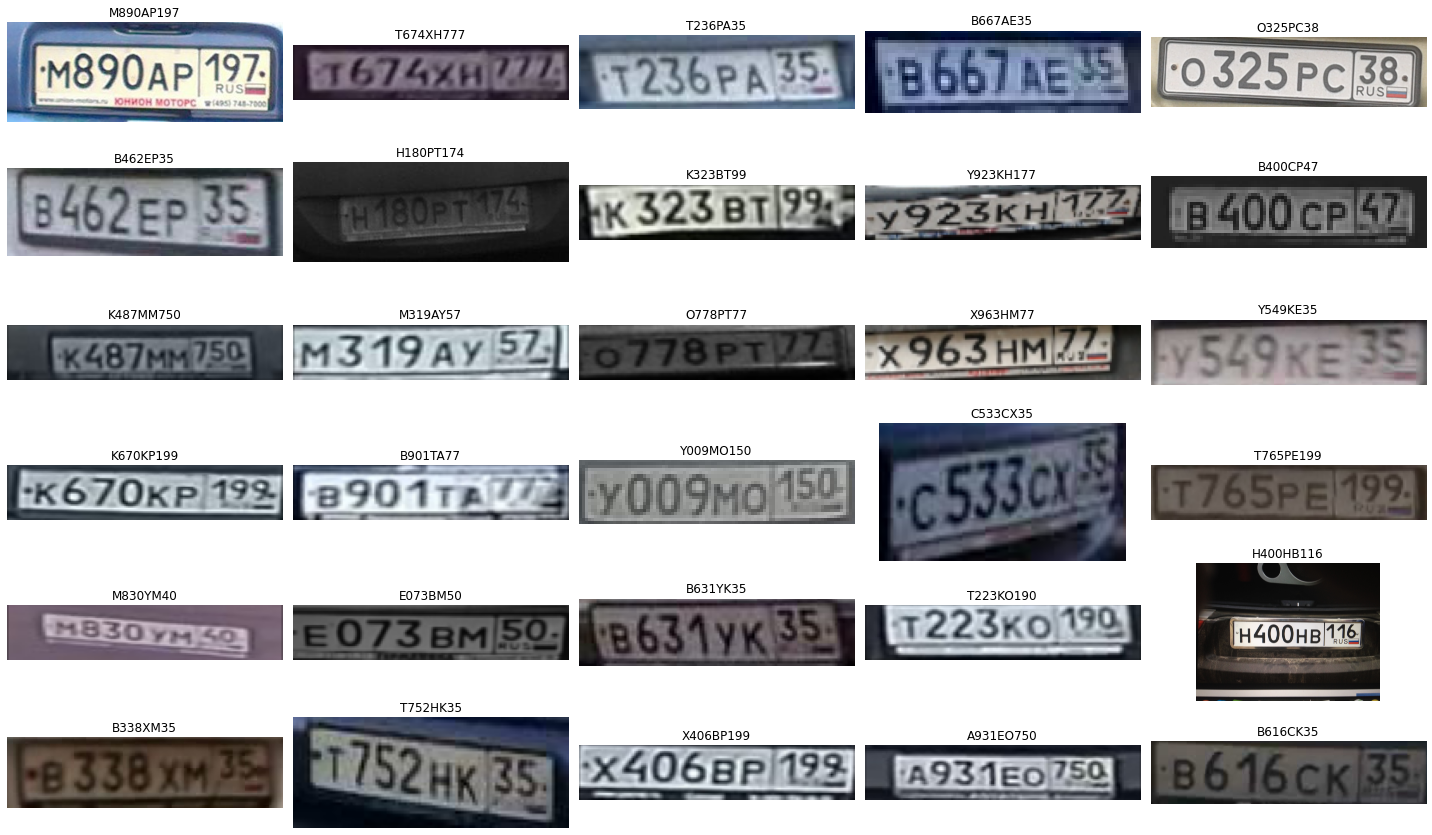

In [167]:
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(config), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    item = config[idx]
    text = item["text"]
    image = cv2.imread(item["file"])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

## Filtering configs

In [168]:
abc = "0123456789ABEKMHOPCTYX"  # this is our alphabet for predictions.

def compute_mask(text):
    """Compute letter-digit mask of text, e.g. 'E506EC152' -> 'LDDDLLDDD'.    
    Args:
        - text: String of text. 
    Returns:
        String of the same length but with every letter replaced by 'L' and every digit replaced by 'D' 
        or None if non-letter and non-digit character met in text.
    """
    mask = []
    for char in text:
        if char in digits:
            mask.append("D")
        elif char in ascii_uppercase:
            mask.append("L")
        else:
            return None

    return "".join(mask)

assert compute_mask("E506EC152") == "LDDDLLDDD"
assert compute_mask("E123KX99") == "LDDDLLDD"
assert compute_mask("P@@@KA@@") is None

In [169]:
def check_in_alphabet(text, alphabet=abc):
    """Check if all chars in text come from alphabet.
    Args:
        - text: String of text.
        - alphabet: String of alphabet.       
    Returns:
        True if all chars in text are from alphabet and False otherwise.
    """
    for char in text:
        if char not in alphabet:
            return False
    return True

assert check_in_alphabet("E506EC152") is True
assert check_in_alphabet("A123GG999") is False

In [170]:
def filter_data(config):
    """Filter config items keeping only ones with correct text.
    
    Args:
        - config: List of dicts, each dict having keys "file" and "text".
        
    Returns:
        Filtered list (config subset).
    """
    config_filtered = []
    for item in tqdm.tqdm(config):
        text = item["text"]
        mask = compute_mask(text)
        if check_in_alphabet(text) and (mask == "LDDDLLDD" or mask == "LDDDLLDDD"):
            config_filtered.append({"file": item["file"],
                                   "text": item["text"]})
    return config_filtered


In [171]:
print("Old len:", len(config))
config = filter_data(config)
print("New len:", len(config))

Old len: 28053


100%|██████████| 28053/28053 [00:00<00:00, 257113.41it/s]

New len: 28053


## Create dataset

In [172]:
class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet=abc, transforms=None):
        """Constructor for class.
        
        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config = config
        self.alphabet = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.config:
            image_name = item["file"]
            text = item['text']
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        image = cv2.imread(self.image_names[item]).astype(np.float32) / 255.
        text = self.texts[item]
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        if self.transforms is not None:
            output = self.transforms(output)
        return output

    def text_to_seq(self, text):
        """Encode text to sequence of integers.
        Args:
            - String of text.    
        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """
        seq = [self.alphabet.find(c) + 1 for c in text]
        
        return seq


In [173]:
class Resize(object):

    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, item):
        """Apply resizing.
        Args: 
            - item: Dict with keys "image", "seq", "seq_len", "text".        
        Returns: 
            Dict with image resized to self.size.
        """
        interpolation = cv2.INTER_AREA if self.size[0] < item["image"].shape[1] else cv2.INTER_LINEAR
        item["image"] = cv2.resize(item["image"], self.size, interpolation=interpolation)
        
        return item


In [174]:
transforms = Resize(size=(320, 64))

simple_dataset = RecognitionDataset(simple_config, alphabet=abc, transforms=transforms)
complex_dataset = RecognitionDataset(complex_config, alphabet=abc, transforms=transforms)
mix_dataset = RecognitionDataset(mix_config, alphabet=abc, transforms=transforms)
test_dataset = RecognitionDataset(test_config, alphabet=abc, transforms=transforms)

In [175]:
print(test_dataset.image_names[0])
print(test_dataset.texts[0])
print(os.path.isfile(test_dataset.image_names[0]))

/kaggle/input/aimasters2022ml3hw4-license-plates/test/test/4353.png
4353
True


In [176]:
print(len(simple_dataset))
print(len(complex_dataset))
print(len(mix_dataset))
print(len(test_dataset))
print(type(simple_dataset))
print(type(complex_dataset))
print(type(mix_dataset))
print(type(test_dataset))

assert dir(simple_dataset) == dir(test_dataset)

11801
16252
28053
7012
<class '__main__.RecognitionDataset'>
<class '__main__.RecognitionDataset'>
<class '__main__.RecognitionDataset'>
<class '__main__.RecognitionDataset'>


Image shape: (64, 320, 3)
Seq: [20, 5, 5, 7, 18, 22, 10, 9] Seq_len: 8
Text: T446PX98


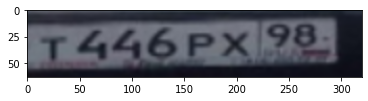

In [177]:
x = simple_dataset[0]
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

Image shape: (64, 320, 3)
Seq: [14, 5, 7, 2, 18, 14, 8, 8, 8] Seq_len: 9
Text: K461PK777


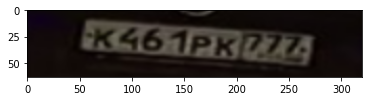

In [178]:
x = mix_dataset[20000]
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

Image shape: (64, 320, 3)
Seq: [12, 4, 1, 4, 20, 19, 4, 6] Seq_len: 8
Text: B303TC35


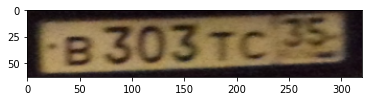

In [179]:
x = complex_dataset[15000]
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

Image shape: (64, 320, 3)
Seq: [5, 4, 6, 4] Seq_len: 4
Text: 4353


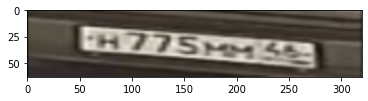

In [180]:
x = test_dataset[0]
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

In [181]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Args:
        - batch: List of dataset __getitem__ return values (dicts).     
    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch


In [182]:
xs = [dataset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


In [183]:
print("Image:"  , batch["image"  ].size())
print("Seq:"    , batch["seq"    ].size())
print("Seq:"    , batch["seq"    ])
print("Seq_len:", batch["seq_len"])
print("Text:"   , batch["text"   ])

Image: torch.Size([4, 3, 64, 320])
Seq: torch.Size([35])
Seq: tensor([20,  5,  5,  7, 18, 22, 10,  9, 11,  2,  2, 10, 11, 17,  8,  8,  8, 20,
         4,  1, 10, 11, 18,  2,  5,  3, 18, 10,  2,  7, 11, 20,  8,  6,  1],
       dtype=torch.int32)
Seq_len: tensor([8, 9, 9, 9], dtype=torch.int32)
Text: ['T446PX98', 'A119AO777', 'T309AP142', 'P916AT750']


# Create model

In [184]:
class FeatureExtractor(Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = Sequential(*list(resnet.children())[:-2])
        
        self.pool = AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.    
        Args:
            - x: Tensor of features (shaped B x C x H x W).
        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features


In [185]:
feature_extractor = FeatureExtractor()

In [186]:
x = torch.randn(1, 3, 64, 320)
y = feature_extractor(x)
assert y.size() == (1, 1, 512, 20)

In [187]:
class SequencePredictor(Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        
        Args:
            - batch_size: Int size of batch
            
        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        
        # YOUR CODE HERE
        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        # END OF YOUR CODE
        
        return h
        
    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.
        
        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).
        
        Returns:
            New tensor shaped (W x B x H).
        """
        
        # YOUR CODE HERE
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        # END OF YOUR CODE
        
        return x
    
    def forward(self, x):
        x = self._reshape_features(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x

In [188]:
sequence_predictor = SequencePredictor(input_size=512, 
                                       hidden_size=128, 
                                       num_layers=2, 
                                       num_classes=len(abc) + 1)

In [189]:
x = torch.randn(1, 1, 512, 20)
assert sequence_predictor._reshape_features(x).size() == (20, 1, 512)

In [190]:
y = sequence_predictor(x)
assert y.size() == (20, 1, 23)

In [191]:
class CRNN(Module):
    
    def __init__(self, alphabet=abc,
                 cnn_input_size=(64, 320), cnn_output_len=20,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(input_size=cnn_input_size, output_len=cnn_output_len)
        self.sequence_predictor = SequencePredictor(input_size=self.features_extractor.num_output_features,
                                                    hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
                                                    num_classes=len(alphabet)+1, dropout=rnn_dropout,
                                                    bidirectional=rnn_bidirectional)
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [192]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

In [193]:
crnn = CRNN()
x = torch.randn(1, 3, 64, 320)
y = crnn(x)
assert y.size() == (20, 1, 23)
decode(y, abc)


['YEOEBOBE4E6']

In [194]:
ACTUALLY_TRAIN = True

In [195]:
crnn = CRNN()



In [196]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
crnn.to(device);

In [197]:
print(torch.cuda.is_available())

True


In [198]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

In [199]:
#state = "SIMPLE"
#state = "COMPLEX"
state = "MIX"

if state == "SIMPLE":
    dataset = simple_dataset
    config = simple_config
elif state == "COMPLEX":
    dataset = complex_dataset
    config = complex_config
else:
    dataset = mix_dataset
    config = mix_config

In [200]:
np.random.shuffle(config)
train_size = int(len(config) * 0.8)
config_train = config[:train_size]
config_val = config[train_size:]

train_dataset = RecognitionDataset(config_train, transforms=Resize())
val_dataset = RecognitionDataset(config_val, transforms=Resize())


In [201]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, 
                              drop_last=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, 
                            drop_last=False, collate_fn=collate_fn)

# Train

In [202]:
num_epochs = 45
batch_size = 128
#num_workers = 4

crnn.train()
if ACTUALLY_TRAIN:
    for i, epoch in enumerate(range(num_epochs)):
        epoch_losses = []

        for j, b in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
            images = b["image"].to(device)
            seqs_gt = b["seq"]
            seq_lens_gt = b["seq_len"]

            seqs_pred = crnn(images).cpu()
            log_probs = log_softmax(seqs_pred, dim=2)
            seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

            loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                            targets=seqs_gt,  # N, S or sum(target_lengths)
                            input_lengths=seq_lens_pred,  # N
                            target_lengths=seq_lens_gt)  # N

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        print(i, np.mean(epoch_losses))
else:
    image_train_log = cv2.imread("./resources/train_log.png")
    plt.figure(figsize=(15, 20))
    plt.imshow(image_train_log[:, :, ::-1], interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    with open("./data/crnn.pth.tar", "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    crnn.load_state_dict(state_dict)

100%|██████████| 175/175 [00:43<00:00,  4.06it/s]


0 2.732994477408273


100%|██████████| 175/175 [00:43<00:00,  4.04it/s]


1 1.239788818018777


100%|██████████| 175/175 [00:43<00:00,  4.06it/s]


2 0.4145873361825943


100%|██████████| 175/175 [00:43<00:00,  4.01it/s]


3 0.1274854723896299


100%|██████████| 175/175 [00:43<00:00,  4.00it/s]


4 0.06923264365111079


100%|██████████| 175/175 [00:42<00:00,  4.08it/s]


5 0.048700310460158755


100%|██████████| 175/175 [00:42<00:00,  4.11it/s]


6 0.04016797953418323


100%|██████████| 175/175 [00:44<00:00,  3.97it/s]


7 0.038037405886820384


100%|██████████| 175/175 [00:42<00:00,  4.07it/s]


8 0.03216555073857307


100%|██████████| 175/175 [00:43<00:00,  4.04it/s]


9 0.031277503642652714


100%|██████████| 175/175 [00:43<00:00,  3.99it/s]


10 0.026613100309457096


100%|██████████| 175/175 [00:43<00:00,  4.04it/s]


11 0.024758812205067704


100%|██████████| 175/175 [00:42<00:00,  4.07it/s]


12 0.01972872406244278


100%|██████████| 175/175 [00:43<00:00,  4.05it/s]


13 0.018157692216336726


100%|██████████| 175/175 [00:43<00:00,  4.06it/s]


14 0.020514167603105305


100%|██████████| 175/175 [00:43<00:00,  4.01it/s]


15 0.018846747183373997


100%|██████████| 175/175 [00:43<00:00,  4.02it/s]


16 0.01764241144593273


100%|██████████| 175/175 [00:42<00:00,  4.10it/s]


17 0.023888147279087987


100%|██████████| 175/175 [00:44<00:00,  3.96it/s]


18 0.020909142393086638


100%|██████████| 175/175 [00:43<00:00,  4.00it/s]


19 0.012983676924237183


100%|██████████| 175/175 [00:43<00:00,  4.03it/s]


20 0.009595168678622161


100%|██████████| 175/175 [00:43<00:00,  4.03it/s]


21 0.011191218560561537


100%|██████████| 175/175 [00:43<00:00,  4.03it/s]


22 0.014122213221022062


100%|██████████| 175/175 [00:44<00:00,  3.96it/s]


23 0.011068798622914723


100%|██████████| 175/175 [00:43<00:00,  4.05it/s]


24 0.008603564587288668


100%|██████████| 175/175 [00:43<00:00,  4.03it/s]


25 0.009079612481540867


100%|██████████| 175/175 [00:44<00:00,  3.96it/s]


26 0.011959866003266402


100%|██████████| 175/175 [00:43<00:00,  3.98it/s]


27 0.01383126019633242


100%|██████████| 175/175 [00:43<00:00,  4.06it/s]


28 0.018378772743578468


100%|██████████| 175/175 [00:43<00:00,  4.02it/s]


29 0.018742229959794455


100%|██████████| 175/175 [00:43<00:00,  4.04it/s]


30 0.011002711057662963


100%|██████████| 175/175 [00:43<00:00,  4.02it/s]


31 0.012490875804796815


100%|██████████| 175/175 [00:43<00:00,  4.03it/s]


32 0.011687683079923902


100%|██████████| 175/175 [00:43<00:00,  4.05it/s]


33 0.012863706170714327


100%|██████████| 175/175 [00:43<00:00,  4.02it/s]


34 0.011737979562687023


100%|██████████| 175/175 [00:43<00:00,  4.02it/s]


35 0.013292212222835848


100%|██████████| 175/175 [00:43<00:00,  4.03it/s]


36 0.00873957189864346


100%|██████████| 175/175 [00:43<00:00,  4.04it/s]


37 0.005989329093801124


100%|██████████| 175/175 [00:43<00:00,  4.04it/s]


38 0.0050124187534675005


100%|██████████| 175/175 [00:43<00:00,  4.04it/s]


39 0.0057108573695378645


100%|██████████| 175/175 [00:42<00:00,  4.07it/s]


40 0.010192729906578149


100%|██████████| 175/175 [00:43<00:00,  4.01it/s]


41 0.013411414318584971


100%|██████████| 175/175 [00:43<00:00,  4.06it/s]


42 0.014133616582091366


100%|██████████| 175/175 [00:43<00:00,  4.05it/s]


43 0.010776923986684


100%|██████████| 175/175 [00:43<00:00,  4.06it/s]

44 0.01023419498199863


# Evaluation

In [208]:
crnn.eval()
if ACTUALLY_TRAIN:
    val_losses = []
    for i, b in enumerate(tqdm.tqdm(val_dataloader, total=len(val_dataloader))):
        images = b["image"].to(device)
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]

        with torch.no_grad():
            seqs_pred = crnn(images).cpu()
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                        targets=seqs_gt,  # N, S or sum(target_lengths)
                        input_lengths=seq_lens_pred,  # N
                        target_lengths=seq_lens_gt)  # N

        val_losses.append(loss.item())

    print(np.mean(val_losses))
else:
    image_val_log = cv2.imread("./resources/val_log.png")
    plt.figure(figsize=(15, 20))
    plt.imshow(image_val_log[:, :, ::-1], interpolation="bilinear")
    plt.axis("off")
    plt.show()

100%|██████████| 44/44 [00:09<00:00,  4.53it/s]

0.04346718315289102


# Collect data

In [212]:
df = pd.DataFrame(columns=["index", "label"])
df

,index,label


In [213]:
for i, b in enumerate(tqdm.tqdm(test_dataloader, total=len(test_dataloader))):
    images = b["image"]
    seqs_gt = b["seq"]
    seq_lens_gt = b["seq_len"]
    texts = b["text"]

    preds = crnn(images.to(device)).cpu().detach()
    ans = decode(preds, crnn.alphabet)
    for j in range(len(texts)):
        row = {'index':int(texts[j].split('.')[0]), 'label':ans[j]}
        df = df.append(row, ignore_index=True)
        

100%|██████████| 55/55 [00:26<00:00,  2.06it/s]


In [214]:
df = df.sort_values(by='index')
df = df.set_index('index')
df

,label
index,
0,B620AE35
1,T955AC35
2,C245CH35
3,C191AA35
4,T544XT777
...,...
7007,C523YB86
7008,B103YY35
7009,B913EE35


In [215]:
dir_to_delete = '/kaggle/working/'
with os.scandir(dir_to_delete) as entries:
    for entry in entries:
        file_to_delete = f"{dir_to_delete}{entry.name}"
        if os.path.isfile(file_to_delete):
            print(file_to_delete)
            os.remove(file_to_delete)

/kaggle/working/abc_submission.csv
/kaggle/working/submission_3.csv
/kaggle/working/lol_submission.csv
/kaggle/working/submission_2.csv
/kaggle/working/kek_submission.csv
/kaggle/working/my_submission.csv
/kaggle/working/submission_1.csv
/kaggle/working/submission_4.csv
/kaggle/working/__notebook_source__.ipynb
/kaggle/working/love_this_submission.csv
/kaggle/working/state.db
/kaggle/working/vitya.csv
/kaggle/working/submission.csv


In [216]:
df.to_csv('submission.csv')